In conclusion, I did two experiments, relating to the image dimensions/size. Both have input image in grayscale with 1 channel only. Moreover, there are 10 classes/labels for the annotations. Both are trained in batch size of 16, and for 40 epochs, with model checkpoint as their callback method. The following are the final results:

1. 256x256(Original Image Dims): Train for at least 45 minutes.(Slower Training Speed) Reaches point of convergence over epoch 15. That means slower learning speed. Takes up 11-12 GB of RAM, and 14-15 GB of GPU.  High resource needed to train. Trained using 1000 training and 200 validation samples.

2. 128x128(Downsized): Train for only 15-20 minutes. (Faster Training Speed) Reaches point of convergence below epoch 15. That means faster learning speed. Takes up 5-6 GB of RAM, and 7-8 GB of GPU. Lower resource needed to train. Trained using 1500 training and 350 validation samples.

In the end, both reaches a training accuracy of 90 %, and validation accuracy of 80 %. I think 128x128 image size produces better results overall than the 256x256 one, because it trains for a shorter time, has a faster learning speed, takes up less resource, to allow more data to be fitted in, taking into account that it has the same train and val accuracy.


***NOTE: Knowing that 256x256 image dimensions already take up lots of resource during training, upscaling it to 512x512 wouldn't be effective, as it will cause the runtime to crash, and the image resolution will still not increase anyway, because the original image dimensions are of 256x256 already.***

**So now we will do further model evaluation, such as IOU analysis and then Model Testing, which includes Model Prediction.**

**IMPORTS**

In [ ]:
from google.colab import drive
from keras.models import load_model
import numpy as np
from keras.metrics import OneHotIoU
import random
import matplotlib.pyplot as plt

**Mount Drive and SetUp Paths**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "enter path here.."

/content/drive/MyDrive/Indonesia AI/Computer Vision/Final Project


In [ ]:
h5model = load_model("128 Image Size Experiment/128_model.h5")

In [ ]:
x_test = np.load('128 Image Size Experiment/x_test.npy')
y_test = np.load('128 Image Size Experiment/y_test.npy')

*Run these two code blocks below only once, the next time just load y_preds.*

In [ ]:
# y_preds = h5model.predict(x_test)

11/11 [==============================] - 161s 15s/step


In [ ]:
# np.save('128 Image Size Experiment/y_preds.npy', y_preds)

In [ ]:
y_preds = np.load('128 Image Size Experiment/y_preds.npy')

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_preds.shape)

(350, 128, 128)
(350, 128, 128, 10)
(350, 128, 128, 10)


We will use OneHotIOU as our evaluation metric, because our labels are one-hot encoded.

In [ ]:
def getMeanIOU():
  iou_scores = []
  for index in range(len(y_preds)):
    y_pred = y_preds[index]
    y_real = y_test[index]

    for i in range(10):
      iou = OneHotIoU(num_classes=10, target_class_ids=[i])
      iou.update_state(y_real, y_pred)

      iou_score = iou.result().numpy()*100
      rounded_iou = np.round(iou_score, 2)

      if index == 0:
        iou_scores.append(rounded_iou)
      else:
        iou_scores[i] += rounded_iou

  mean_iou = np.array(iou_scores)/len(y_preds)
  return np.round(mean_iou, 2)

In [ ]:
mean_iou_per_class = getMeanIOU()

In [ ]:
total_iou = 0
for iou in mean_iou_per_class:
  total_iou += iou
mean_iou = total_iou/len(mean_iou_per_class)
mean_iou = np.round(mean_iou, 2)

In [ ]:
class_map = {
    'unlabeled':(0, 0, 0),
    'sky':(70, 130, 180),
    'building':(70, 70, 70),
    'pole':(153, 153, 153),
    'road':(128, 64, 128),
    'sidewalk':(244, 35, 232),
    'vegetation':(107, 142, 35),
    'car':( 0, 0, 142),
    'person':(220, 20, 60),
    'traffic sign':(220, 220, 0)
}

In [ ]:
labels = list(class_map.keys())
unique_colors = list(class_map.values())

In [ ]:
label_iou = dict(zip(labels, mean_iou_per_class))
print("Mean IOU per Class: ", label_iou)
print("Mean IOU For All Classes: ", mean_iou)

Mean IOU per Class:  {'unlabeled': 80.99, 'sky': 54.21, 'building': 56.41, 'pole': 10.36, 'road': 83.19, 'sidewalk': 34.97, 'vegetation': 58.27, 'car': 51.48, 'person': 14.49, 'traffic sign': 4.46}
Mean IOU For All Classes:  44.88


In [ ]:
def color_annotations(image):
  visualization = image.copy()
  visualization = np.repeat(visualization.reshape(128, 128, 1), 3, axis=2)
  visualization = visualization.reshape(-1, 3)

  for i in range(len(visualization)):
    visualization[i] = unique_colors[visualization[i][0]]

  visualization = visualization.reshape(128, 128, 3)

  return visualization

In [ ]:
def predict(index):
  y_pred = y_preds[index]
  y_real = y_test[index]
  iou_scores = []

  for i in range(10):
    iou = OneHotIoU(num_classes=10, target_class_ids=[i])
    iou.update_state(y_real, y_pred)
    iou_score = iou.result().numpy()*100
    iou_scores.append(np.round(iou_score, 2))

  y_pred = np.argmax(y_pred, axis=2)
  y_real = np.argmax(y_real, axis=2)
  x = x_test[index]

  spotted_labels = np.unique(y_pred)

  y_pred = color_annotations(y_pred)
  y_real = color_annotations(y_real)

  fig, axes = plt.subplots(1, 3, figsize=(15,5))
  axes[0].imshow(x, cmap='gray')
  axes[0].set_title('Original Image')

  axes[1].imshow(y_real)
  axes[1].set_title('Annotation')

  axes[2].imshow(y_pred)
  axes[2].set_title('Predicted Segmentation')

  return iou_scores, spotted_labels

Labels Spotted in Image:  ['sky', 'building', 'pole', 'road', 'sidewalk', 'vegetation', 'car', 'person', 'traffic sign']
IOU per Class:  {'unlabeled': 82.75, 'sky': 84.09, 'building': 19.71, 'pole': 20.42, 'road': 74.7, 'sidewalk': 2.17, 'vegetation': 72.75, 'car': 56.14, 'person': 29.31, 'traffic sign': 4.98}
Mean IOU For All Classes:  44.7


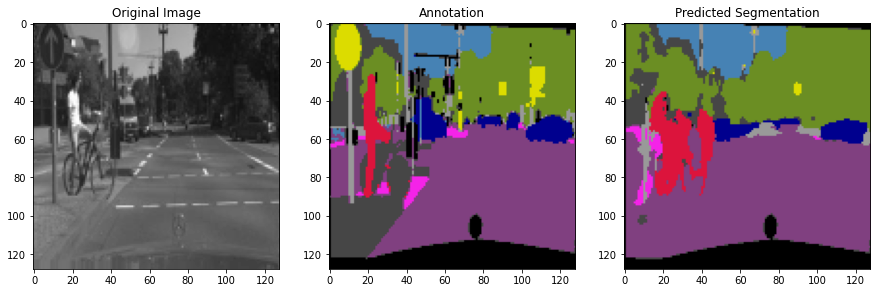

In [ ]:
index = random.randint(0, len(y_preds)-1)
iou_scores, spotted_labels = predict(index)

total_iou = 0
for iou in iou_scores:
  total_iou += iou
mean_iou = total_iou/len(iou_scores)
mean_iou = np.round(mean_iou, 2)

label_iou = dict(zip(labels, iou_scores))

list_of_labels = []
for index in spotted_labels:
  list_of_labels.append(labels[index])

print("Labels Spotted in Image: ", list_of_labels[1:])
print("IOU per Class: ", label_iou)
print("Mean IOU For All Classes: ", mean_iou)